In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import math
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# Dot Product and Angle calculation functions --
def get_dotproduct(x, y):
    return sum((a * b) for a, b in zip(x, y))

def get_angle(x, y):
    return (get_dotproduct(x, y) / (get_length(x) * get_length(y)))

def get_length(x):
    return math.sqrt(get_dotproduct(x, x))

In [8]:
# Distance between points
def points_distance(x, y):
    total_sum = 0
    for z in (y - x):
        total_sum += z ** 2
        
    return math.sqrt(total_sum)


# Calculate normal value
def norm_val(val):
    total_sum = 0
    for x in val:
        total_sum += x**2
    return math.sqrt(total_sum)


# Calculate cross product
def get_crossproduct(arr):
    temp_arr = []
    for i in range(len(arr)):
        for j in range(i + 1, len(arr)):
            temp_arr.append([i + 1, j + 1, np.cross(arr[i], arr[j])])
            
    temp_arr = np.array(temp_arr, dtype='object')
    
    return temp_arr

In [9]:
# Planes planarity --
def plane_planarity(plane):
    flatness = True
    for i in plane.values():
        # precision value for planarity check
        if (abs(i) < 0.97): 
            flatness = False
            return flatness
        
    return flatness

# Angle planarity -- 
def angle_planarity(arr):
    temp_arr = {}
    
    for i in range(len(arr)):
        for j in range(i + 1, len(arr)):
            x = ''.join([str(arr[i][0]), ',', str(arr[i][1]), '->', str(arr[j][0]), ',', str(arr[j][1])])
            temp_arr[x] = get_angle(arr[i][2], arr[j][2])
            
    return temp_arr

# Angle consistency --
def angle_fix(angle_matrix):
    consistent = True
    first_angle = True
    first_angle_val = -9
    threshold_val = 6
    
    for i in angle_matrix:
        for j in i:
            for k in j:
                if (k != -9):
                    if first_angle:
                        first_angle_val = k
                        first_angle = False
                    if abs(k - first_angle_val) > threshold_val:
                        consistent = False
                        return consistent
    return consistent

In [10]:
# Find consistency between distance
def is_distance_consistent(distance_matrix):
    consistent = True
    is_first_distance = True
    first_distance = -9
    threshold_value = 0.1
    
    for i in distance_matrix:
        for j in i:
            if j != -9:
                if is_first_distance:
                    first_distance = j
                    is_first_distance = False
                if (abs(j - first_distance) > threshold_value):
                    consistent = False
                    return consistent
    return consistent

# Calculate total distance
def find_total_dist_sum(array):
    total = 0
    for i in range(len(array)):
        for j in range(i + 1, len(array)):
            total += points_distance(array[i], array[j])
    return total

# Initialize random points
def init_random_points(points, dimensions):
    vec = np.random.randn(points, dimensions)
    vec = np.array(vec)
    
    for i in range(len(vec)): vec[i] = vec[i] / get_length(vec[i])
        
    return vec

In [11]:
def angle_vs_distance_reg(val):
    angle_matrix = [[-9.0]] * (len(val) * len(val) * len(val))
    dist_matrix = [-9.0] * (len(val) * len(val))
    
    angle_matrix = np.array(angle_matrix).reshape((len(val), len(val), len(val)))
    dist_matrix = np.array(dist_matrix).reshape((len(val), len(val)))

    is_distance = False
    points = np.array(val)
    
    for i in range(len(val)):
        for j in range(len(val)):
            for k in range(j + 1, len(val)):
                if (i != j and i != k):
                    vector_1 = val[j] - val[i]
                    vector_2 = val[k] - val[i]
                    angle_matrix[i][j][k] = math.degrees(math.acos(get_angle(vector_1, vector_2)))

                if not is_distance:
                    dist_matrix[j][k] = points_distance(val[j], val[k])
        is_distance = True

    return [angle_matrix, dist_matrix, angle_fix(angle_matrix)]

In [12]:
# plot the 3D graph
def graph_3D(arr):
    fig = plt.figure(figsize=(4, 4))
    axis = fig.add_subplot(111, projection='3d')

    for i in range(len(arr)):
        axis.scatter(arr[i][0], arr[i][1], arr[i][2])
        for j in range(i + 1, len(arr)):
            axis.plot([arr[i][0], arr[j][0]], [arr[i][1], arr[j][1]], [arr[i][2], arr[j][2]])

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = 1 * np.outer(np.cos(u), np.sin(v))
    y = 1 * np.outer(np.sin(u), np.sin(v))
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
    axis.plot_surface(x, y, z, rstride=4, cstride=4, color='y', linewidth=0, alpha=0.2)
    plt.show()

**Problem 3** -- Write code to find a 3-configuration on n points. Be clear as to your method andapproach, and any math that you do to formulate it. Comment your code thoroughly. Hint: What dimensiondo you really need to solve an optimization problem for?

In [13]:
# Intializing values
initial_beta = 10
alpha = 0.0001
iterations = 20000
beta_iterations = 50

def gradient_descent(arr):
    beta = initial_beta
    arr = np.array(arr)

    for iter in range(beta_iterations):
        for iteration in range(iterations):
            sum_column = [0] * len(arr[0])

            for i in range(0, len(arr)):
                for j in range(0, len(arr[0])):
                    sum_column[j] += arr[i][j]

            sum_square = [0] * len(arr)
            
            for i in range(1, len(arr)):
                sum_square[i] = np.sum(np.square(arr[i])) - 1

            temp = np.zeros((len(arr), len(arr[0])))

            for i in range(1, len(arr)):
                is_beta = False
                norm_value = norm_val(arr[i])
                for j in range(len(arr)):
                    if i != j:
                        distance = points_distance(arr[i],arr[j])
                        temp[i] -= np.multiply(arr[i] - arr[j] , 1/distance)
                        if not is_beta:
                            p = float(beta*(1 - (1/norm_value)))
                            temp[i] += np.multiply( arr[i] ,p )
                            is_beta = True

            arr = arr - np.multiply(temp, alpha)

        print(arr, iter, " ", find_total_dist_sum(arr), sum_square)
        beta += 20
        
    return arr


**Problem 4** -- Find a three-point 3-configuration. Show that the configuration is flat.

In [68]:
arr = [[-1, 0, 0]]

# points left to be finalized
n_points = 2  
n_dimensions = len(arr[0])

vec = init_random_points(n_points, n_dimensions)
for x in range(len(vec)): arr.insert(x + 1, vec[x])
arr = np.array(arr)

print(arr)

[[-1.          0.          0.        ]
 [-0.16675426  0.13458278  0.97677044]
 [-0.78902747  0.20914683 -0.57766188]]


In [69]:
# Optimization to find the rest two points
final_output = gradient_descent(arr)

[[-1.          0.          0.        ]
 [ 0.65687416 -0.048524    0.98316472]
 [ 0.20012358  0.1487121  -1.14652346]] 0   5.780666314429802 [0, 0.40045189960531413, 0.3766806360502961]
[[-1.          0.          0.        ]
 [ 0.59485548 -0.07849819  0.87256592]
 [ 0.4159458   0.09626222 -0.96736347]] 1   5.394036599569413 [0, 0.12138637295766519, 0.11806935319364587]
[[-1.          0.          0.        ]
 [ 0.5479472  -0.08266556  0.87413688]
 [ 0.47131358  0.08764911 -0.91679457]] 2   5.316062342927867 [0, 0.071195033627943, 0.07033111757438903]
[[-1.          0.          0.        ]
 [ 0.52432457 -0.08332422  0.87664893]
 [ 0.49135198  0.08518754 -0.89522152]] 3   5.2820709470182345 [0, 0.050372526870378076, 0.05010524539001282]
[[-1.          0.          0.        ]
 [ 0.51334267 -0.08336817  0.87665163]
 [ 0.49918784  0.08414029 -0.88466455]] 4   5.2630049596976844 [0, 0.03898903191453851, 0.038899443837085546]
[[-1.          0.          0.        ]
 [ 0.50819841 -0.08326924  0.8

In [70]:
for out in final_output:
    print(np.sum(np.square(out)))
    
# The cooridnates
print(final_output) 
# Total distance
print(find_total_dist_sum(final_output))

1.0
1.0035028347338886
1.0035028347338886
[[-1.          0.          0.        ]
 [ 0.50058241 -0.08215211  0.86381197]
 [ 0.50058241  0.08215211 -0.86381197]]
5.2022147957158005


In [71]:
# Verification of points being flat
cross_product_vectors = get_crossproduct(final_output)
cross_product_angels = angle_planarity(cross_product_vectors)
print("planar angles are",cross_product_angels)

planar angles are {'1,2->1,3': -1.0, '1,2->2,3': 1.0, '1,3->2,3': -1.0}


In [72]:
print("The  given point configuration is a plane:", plane_planarity(cross_product_angels))

The  given point configuration is a plane: True


**Problem 6** -- distance and angle for 3-point 3-configuration

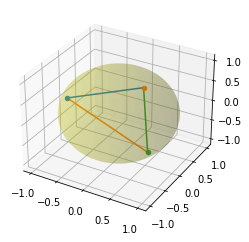

In [73]:
graph_3D(final_output)

In [74]:
[angle_matrix, distance_matrix, regularity] = angle_vs_distance_reg(final_output)
print("--------------------------------------------------------------------")
print("The Angle Matrix is")
print(angle_matrix)
print("--------------------------------------------------------------------")
print("The Distance Matrix is")
print(distance_matrix)
print("--------------------------------------------------------------------")
print("The point d configuration is regular: ", regularity)

--------------------------------------------------------------------
The Angle Matrix is
[[[-9.         -9.         -9.        ]
  [-9.         -9.         60.07717585]
  [-9.         -9.         -9.        ]]

 [[-9.         -9.         59.96141207]
  [-9.         -9.         -9.        ]
  [-9.         -9.         -9.        ]]

 [[-9.         59.96141207 -9.        ]
  [-9.         -9.         -9.        ]
  [-9.         -9.         -9.        ]]]
--------------------------------------------------------------------
The Distance Matrix is
[[-9.          1.73339772  1.73339772]
 [-9.         -9.          1.73541936]
 [-9.         -9.         -9.        ]]
--------------------------------------------------------------------
The point d configuration is regular:  True


**Problem 5** -- Find a four-point 3-configuration. Show that the configuration isn’t flat.

In [75]:
arr = [[-1, 0, 0]]

# points left to be finalized
n_points = 3  
n_dimensions = len(arr[0])

vec = init_random_points(n_points, n_dimensions)
for x in range(len(vec)): arr.insert(x + 1, vec[x])
arr = np.array(arr)

print(arr)

[[-1.          0.          0.        ]
 [-0.45445681  0.5388619  -0.70929321]
 [ 0.12605895 -0.73299228 -0.66845453]
 [-0.42652535 -0.67846731 -0.59812895]]


In [76]:
final_output = gradient_descent(arr)

[[-1.          0.          0.        ]
 [ 0.14388753  1.24522834 -0.09399032]
 [ 1.1978878  -0.34056463  0.05185451]
 [-0.33404778 -1.18295619 -0.16397007]] 0   11.432600879179429 [0, 0.580132366513505, 0.5536086870790522, 0.5378577533695221]
[[-1.          0.          0.        ]
 [ 0.10483634  1.07637944 -0.04735601]
 [ 1.06092275 -0.11888477  0.16992132]
 [-0.13480162 -1.06087031 -0.15294918]] 1   10.247255165733309 [0, 0.17182604392163836, 0.16856393304136286, 0.1670106386919865]
[[-1.          0.          0.        ]
 [ 0.06329794  1.04286261 -0.09365874]
 [ 1.0091954  -0.06294317  0.27756553]
 [-0.0483752  -1.02479255 -0.21570391]] 2   10.024876837067403 [0, 0.10034102891249774, 0.09947980160340575, 0.09906806852737438]
[[-1.          0.          0.        ]
 [ 0.06387422  1.01841782 -0.17219753]
 [ 0.93932744 -0.04673383  0.43158284]
 [ 0.01377778 -0.98909686 -0.30334675]] 3   9.947720416687064 [0, 0.0709067555343812, 0.07078381514231924, 0.07052165560626178]
[[-1.          0.  

In [77]:
for out in final_output:
    print(np.sum(np.square(out)))
    
# The cooridnates    
print(final_output)
# Total distance
print(find_total_dist_sum(final_output))

1.0
1.0049558120834874
1.0049558120834872
1.004955812083487
[[-1.          0.          0.        ]
 [ 0.33382758  0.84974418 -0.41406496]
 [ 0.33382758 -0.06628131  0.94293252]
 [ 0.33382758 -0.78346286 -0.52886756]]
9.816147531702294


In [78]:
cross_product_vectors = get_crossproduct(final_output)
cross_product_angels = angle_planarity(cross_product_vectors)
print("planar angles are: ")

for x in cross_product_angels.items():
    print(x)

planar angles are: 
('1,2->1,3', -0.49999999999998784)
('1,2->1,4', -0.5000000000000275)
('1,2->2,3', 0.49962874618178826)
('1,2->2,4', 0.49962874618167863)
('1,2->3,4', 9.95538105847592e-14)
('1,3->1,4', -0.49999999999998473)
('1,3->2,3', -0.49962874618170444)
('1,3->2,4', 1.5419682679303408e-15)
('1,3->3,4', 0.4996287461816993)
('1,4->2,3', -9.800409373256788e-14)
('1,4->2,4', -0.4996287461816812)
('1,4->3,4', -0.49962874618178554)
('2,3->2,4', -0.500742231977738)
('2,3->3,4', 0.5007422319778012)
('2,4->3,4', -0.5007422319777383)


In [79]:
print("The  given point configuration is a plane:", plane_planarity(cross_product_angels))

The  given point configuration is a plane: False


**Problem 6** -- distance and angle for 4-point 3-configuration

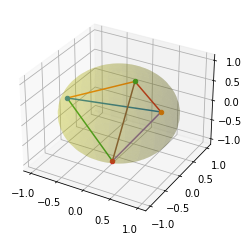

In [80]:
graph_3D(final_output)

In [81]:
[angle_matrix, distance_matrix, regularity] = angle_vs_distance_reg(final_output)
print("--------------------------------------------------------------------")
print("The Angle Matrix is")
print(angle_matrix)
print("--------------------------------------------------------------------")
print("The Distance Matrix is")
print(distance_matrix)
print("--------------------------------------------------------------------")
print("The point d configuration is regular: ", regularity)

--------------------------------------------------------------------
The Angle Matrix is
[[[-9.         -9.         -9.         -9.        ]
  [-9.         -9.         60.09815171 60.09815171]
  [-9.         -9.         -9.         60.09815171]
  [-9.         -9.         -9.         -9.        ]]

 [[-9.         -9.         59.95092414 59.95092414]
  [-9.         -9.         -9.         -9.        ]
  [-9.         -9.         -9.         60.        ]
  [-9.         -9.         -9.         -9.        ]]

 [[-9.         59.95092414 -9.         59.95092414]
  [-9.         -9.         -9.         60.        ]
  [-9.         -9.         -9.         -9.        ]
  [-9.         -9.         -9.         -9.        ]]

 [[-9.         59.95092414 59.95092414 -9.        ]
  [-9.         -9.         60.         -9.        ]
  [-9.         -9.         -9.         -9.        ]
  [-9.         -9.         -9.         -9.        ]]]
--------------------------------------------------------------------
Th

**Problem 6** - done above

**Problem 7** - Find five-point 3-configurations. What can you say about the sets of distances andangles between the points? How many distinct five-point configurations can you find?

In [82]:
arr = [[-1, 0, 0]]

# points left to be finalized
n_points = 4  
n_dimensions = len(arr[0])

vec = init_random_points(n_points, n_dimensions)
for x in range(len(vec)): arr.insert(x + 1, vec[x])
arr = np.array(arr)

print(arr)

[[-1.          0.          0.        ]
 [-0.67681797 -0.09792069  0.72960878]
 [-0.6964516  -0.69768355 -0.16790721]
 [ 0.38127418  0.36328068  0.85009244]
 [ 0.14285577 -0.54884397 -0.82362766]]


In [83]:
final_output = gradient_descent(arr)

[[-1.          0.          0.        ]
 [-0.36472523  0.23715658  1.24537507]
 [-0.32019587 -1.18127291 -0.49332292]
 [ 0.99539478  0.73564052  0.45392491]
 [ 0.74083598  0.04549659 -1.09223086]] 0   19.537363743770737 [0, 0.7402261634979674, 0.7412975209541917, 0.73802679782548, 0.7438769692316647]
[[-1.          0.          0.        ]
 [-0.19652222  0.1415491   1.07748723]
 [-0.0181437  -1.06834601 -0.2840961 ]
 [ 0.85081601  0.64511987  0.2819463 ]
 [ 0.41682749  0.22779913 -0.99829553]] 1   16.92321194206471 [0, 0.21963584757073384, 0.2224029153999767, 0.21956121581263166, 0.2222315124329095]
[[-1.          0.          0.        ]
 [-0.13895899  0.08705007  1.04975337]
 [ 0.14999978 -1.03460014 -0.19483039]
 [ 0.83810106  0.62016217  0.20544826]
 [ 0.18594957  0.30242726 -1.00223445]] 2   16.44557702217129 [0, 0.12886942461042916, 0.13085625051299332, 0.12922346736218082, 0.1305133905564908]
[[-1.          0.          0.        ]
 [-0.10758465  0.06097172  1.03733207]
 [ 0.2410645

In [84]:
for out in final_output:
    print(np.sum(np.square(out)))
    
# The cooridnates    
print(final_output)
# Total distance
print(find_total_dist_sum(final_output))

1.0
1.006317859774644
1.006367795778929
1.0063676166798503
1.006317859774644
[[-1.          0.          0.        ]
 [-0.00103918 -0.15177264  0.99160569]
 [ 0.50115325 -0.85896986 -0.1318484 ]
 [ 0.50267095  0.85810291  0.13171532]
 [-0.00103918  0.15262226 -0.99147528]]
15.721131254323684


In [85]:
cross_product_vectors = get_crossproduct(final_output)
cross_product_angels = angle_planarity(cross_product_vectors)

print("planar angles are: ")

for x in cross_product_angels.items():
    print(x)

planar angles are: 
('1,2->1,3', -0.0004284377374244356)
('1,2->1,4', 0.00042843773742572963)
('1,2->1,5', -0.9999996328822102)
('1,2->2,3', 0.4995647501336791)
('1,2->2,4', 0.5010782680904804)
('1,2->2,5', -0.9240854207651337)
('1,2->3,4', -0.0004284377374251194)
('1,2->3,5', 0.49956533568676087)
('1,2->4,5', 0.5010773159598682)
('1,3->1,4', -1.0)
('1,3->1,5', -0.0004284377374235758)
('1,3->2,3', 0.0006833584330630941)
('1,3->2,4', -0.001111165671382214)
('1,3->2,5', 3.59427238907691e-16)
('1,3->3,4', 1.0)
('1,3->3,5', -0.0006833584330632686)
('1,3->4,5', 0.0011111656713815794)
('1,4->1,5', 0.0004284377374222875)
('1,4->2,3', -0.0006833584330624536)
('1,4->2,4', 0.0011111656713828696)
('1,4->2,5', -1.5498662174600043e-15)
('1,4->3,4', -1.0000000000000002)
('1,4->3,5', 0.0006833584330639309)
('1,4->4,5', -0.0011111656713809158)
('1,5->2,3', -0.49956533568676087)
('1,5->2,4', -0.501077315959868)
('1,5->2,5', 0.9240854207651337)
('1,5->3,4', -0.00042843773742292973)
('1,5->3,5', -0.49956

In [86]:
print("The  given point configuration is a plane:", plane_planarity(cross_product_angels))

The  given point configuration is a plane: False


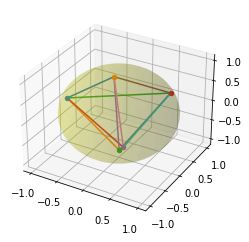

In [87]:
graph_3D(final_output)

In [88]:
[angle_matrix, distance_matrix, regularity] = angle_vs_distance_reg(final_output)
print("--------------------------------------------------------------------")
print("The Angle Matrix is")
print(angle_matrix)
print("--------------------------------------------------------------------")
print("The Distance Matrix is")
print(distance_matrix)
print("--------------------------------------------------------------------")
print("The point d configuration is regular: ", regularity)

--------------------------------------------------------------------
The Angle Matrix is
[[[-9.         -9.         -9.         -9.         -9.        ]
  [-9.         -9.         52.37258197 52.32820291 90.23995385]
  [-9.         -9.         -9.         60.0836451  52.37258197]
  [-9.         -9.         -9.         -9.         52.32820291]
  [-9.         -9.         -9.         -9.         -9.        ]]

 [[-9.         -9.         75.44348564 75.50465677 44.88002308]
  [-9.         -9.         -9.         -9.         -9.        ]
  [-9.         -9.         -9.         75.48153966 45.02618156]
  [-9.         -9.         -9.         -9.         45.0049921 ]
  [-9.         -9.         -9.         -9.         -9.        ]]

 [[-9.         52.18393239 -9.         59.98315153 52.18393239]
  [-9.         -9.         -9.         52.24553489 89.94763688]
  [-9.         -9.         -9.         -9.         -9.        ]
  [-9.         -9.         -9.         -9.         52.24553489]
  [-9.     

**Problem 8** -- For a Goncharov d-configuration on n points, call it k-regular if it has k many‘classes’ of points, based on sets of distances and angles to the other points when measured from any point(essentially, k different views of the other points are possible, depending on which point you stand on). Forn = 2, 3, 4, . . . , 20, characterize all the 3-configurations you can find in terms of their regularity.

In [14]:
def is_in_dict( j , temp , thresh):
    val_bool = False
    val = -9
    for x in temp.keys():
        if(abs(x - j) <= thresh):
            temp[x] +=1
            return  temp
        else:
            val_bool = True
            val = j
            # temp[j] =1
            # return temp
    if(val_bool):
        temp[val] = 1
        return  temp

def updated_point_dict(point_dict):
    a = point_dict
    import copy
    temp = copy.deepcopy(a)
    threshold = 0.05
    unique_list = []

    for key in a:
        dic = a[key]
        for k in dic:
            # traverse
            match_found = False
            for value, parent in unique_list:
                if abs(value - k) <= threshold:
                    sub_dictionary = temp[key]
                    target = sub_dictionary[k]
                    del sub_dictionary[k]
                    sub_dictionary[value] = target
                    match_found = True
                    break

            if not match_found:
                unique_list.append((k, key))

    a = temp
    return a


def distance_based_classes(distance_matrix ,arr_len):
    distance_matrix = pd.DataFrame(distance_matrix)
    point_dict = {}
    classes = {}
    for i in range(arr_len):
        temp = {}
        for j in pd.concat([distance_matrix.iloc[i, i + 1:], distance_matrix.iloc[:i, i]]):
            j = round(j, 2)
            if (len(temp)!= 0):
                temp = is_in_dict( j , temp , 0.05)
            else:
                temp[j] =1
        point_dict[i] = temp

    point_dict = updated_point_dict(point_dict)  # precision
    for x in point_dict:
        key = frozenset(point_dict[x].items())
        if not key in classes:
            classes[key] = [x]
        else:
            classes[key].append(x)

    return [point_dict,classes]

def angle_based_classes(angle_matrix , arr_len):
    point_dict = {}
    classes = {}
    for i in range(arr_len):
        temp = {}
        for j in angle_matrix[i].reshape(len(angle_matrix[i]) ** 2, 1):
            if j[0] != -9.0:
                j = round(j[0])
                if (len(temp) != 0):
                    temp = is_in_dict(j, temp, 5)
                else:
                    temp[j] = 1
        point_dict[i] = temp
    point_dict = updated_point_dict(point_dict)

    for x in point_dict:
        key = frozenset(point_dict[x].items())
        if not key in classes:
            classes[key] = [x]
        else:
            classes[key].append(x)

    return [point_dict, classes]

In [17]:
def k_regular_class_points():
    angle_classes_list = []
    distance_classes_list = []
    angle_matrices = []
    distance_matrices = []
    dimension = 3
    num_of_points = 1
    for num_of_points in range(2,21):
        arr_input = []
        v = init_random_points(num_of_points, dimension)
        for x in range(len(v)):
            arr_input.insert(x + 1, v[x])
        arr_input = np.array(arr_input)
        output = gradient_descent(arr_input)
        [angle_matrix, distance_matrix, regularity] = angle_vs_distance_reg(output)
        angle_matrices.append(angle_matrix)
        distance_matrices.append(distance_matrix)

        angle_classes = angle_based_classes(angle_matrix , len(output) )
        angle_classes_list.append(angle_classes)
        distance_classes = distance_based_classes(distance_matrix , len(output))
        distance_classes_list.append(distance_classes)
        print("iteration point",num_of_points)
    return [ distance_classes_list , angle_classes_list ]

In [18]:
big_val = k_regular_class_points()

[[-0.2651416   0.94615934 -0.18569446]
 [-0.01825957 -1.09733068  0.0524672 ]] 0   2.0720818435259707 [0, 0.20722059509427182]
[[-0.2651416   0.94615934 -0.18569446]
 [ 0.16294722 -1.01093384  0.13822881]] 1   2.0293841495232368 [0, 0.06764620895861717]
[[-0.2651416   0.94615934 -0.18569446]
 [ 0.22930758 -0.97930097  0.16963624]] 2   2.0194398454303153 [0, 0.04038879910943072]
[[-0.2651416   0.94615934 -0.18569446]
 [ 0.25362387 -0.96523889  0.1810061 ]] 3   2.014207066258416 [0, 0.028774386774244487]
[[-0.2651416   0.94615934 -0.18569446]
 [ 0.26239104 -0.95878115  0.18502757]] 4   2.0111001451774233 [0, 0.022345557176109088]
[[-0.2651416   0.94615934 -0.18569446]
 [ 0.26543347 -0.95555044  0.18636757]] 5   2.0090893874786464 [0, 0.01826444897764712]
[[-0.2651416   0.94615934 -0.18569446]
 [ 0.26639413 -0.95373159  0.18674584]] 6   2.0076920972980057 [0, 0.015443785363878693]
[[-0.2651416   0.94615934 -0.18569446]
 [ 0.26661712 -0.95257632  0.1867925 ]] 7   2.006666637652757 [0, 0.01

In [25]:
distance_class_list = big_val[0]
angle_class_list = big_val[1]

# k-distance
print("k-distances")
for x in range(len(distance_class_list)):
    print("The number of classes for {} point 3 configuration is {}".format(x + 2,len(distance_class_list[x][-1])))

k-distances
The number of classes for 2 point 3 configuration is 1
The number of classes for 3 point 3 configuration is 1
The number of classes for 4 point 3 configuration is 1
The number of classes for 5 point 3 configuration is 2
The number of classes for 6 point 3 configuration is 1
The number of classes for 7 point 3 configuration is 7
The number of classes for 8 point 3 configuration is 1
The number of classes for 9 point 3 configuration is 2
The number of classes for 10 point 3 configuration is 2
The number of classes for 11 point 3 configuration is 11
The number of classes for 12 point 3 configuration is 1
The number of classes for 13 point 3 configuration is 11
The number of classes for 14 point 3 configuration is 2
The number of classes for 15 point 3 configuration is 5
The number of classes for 16 point 3 configuration is 2
The number of classes for 17 point 3 configuration is 3
The number of classes for 18 point 3 configuration is 4
The number of classes for 19 point 3 confi

In [35]:
# k-angles
print("k-angles")
for x in range(len(angle_class_list)):
    print("The number of classes for {} point 3 configuration is {}".format(x + 2,len(angle_class_list[x][-1])))

k-angles
The number of classes for 2 point 3 configuration is 1
The number of classes for 3 point 3 configuration is 1
The number of classes for 4 point 3 configuration is 1
The number of classes for 5 point 3 configuration is 2
The number of classes for 6 point 3 configuration is 1
The number of classes for 7 point 3 configuration is 7
The number of classes for 8 point 3 configuration is 1
The number of classes for 9 point 3 configuration is 2
The number of classes for 10 point 3 configuration is 2
The number of classes for 11 point 3 configuration is 11
The number of classes for 12 point 3 configuration is 1
The number of classes for 13 point 3 configuration is 11
The number of classes for 14 point 3 configuration is 2
The number of classes for 15 point 3 configuration is 5
The number of classes for 16 point 3 configuration is 2
The number of classes for 17 point 3 configuration is 3
The number of classes for 18 point 3 configuration is 5
The number of classes for 19 point 3 configur

**Problem 9** -- For what n are Goncharov 4-configurations less than four-dimensional? Whatdimension are they? What shapes do they correspond to? Show your work. Note you’ll need to extend theprevious calculations and code by one dimension.

In [89]:
def dimension_verify():
    angle_arr = []
    distance_arr = []
    dimension = 4
    num_of_points = 1
    point_found = False
    point_value = None
    
    while not point_found:
        arr_input = []
        v = init_random_points(num_of_points, dimension)
        for x in range(len(v)):
            arr_input.insert(x + 1, v[x])
        arr_input = np.array(arr_input)
        output = gradient_descent(arr_input)
        
        [angle_matrix, distance_matrix, regularity] = angle_vs_distance_reg(output)
        angle_arr.append(angle_matrix)
        distance_arr.append(distance_matrix)
        rank = np.linalg.matrix_rank(output)
        
        if rank == dimension:
            point_found = True
            point_value = num_of_points - 1
        num_of_points += 1

    print(f"4 Dimension  {point_value}")
    for p in range(len(distance_arr)):
        print("===============================================")
        print("Points considering",p+1)
        print(" The distance matrix is : ")
        print(distance_arr[p])
        print(" The angle matrix is  : ")
        print(angle_arr[p])
        print("===============================================")

In [90]:
dimension_verify()

[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 0   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 1   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 2   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 3   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 4   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 5   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 6   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 7   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 8   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 9   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 10   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 11   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 12   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 13   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 14   0 [0]
[[ 0.60591308  0.5080966  -0.13432573 -0.59721335]] 15   0 [0]
[[

**Problem 10** - Find a regular 4-configuration that is four dimensional. What n did you find?

In [95]:
def four_dimensions():
    angle_arr = []
    distance_arr = []
    ranks = []
    dimension = 4
    
    for num_of_points in range(5,9):
        arr_input = []
        v = init_random_points(num_of_points, dimension)
        for x in range(len(v)):
            arr_input.insert(x + 1, v[x])
            
        arr_input = np.array(arr_input)
        output = gradient_descent(arr_input)
        
        [angle_matrix, distance_matrix, regularity] = angle_vs_distance_reg(output)
        angle_arr.append(angle_matrix)
        distance_arr.append(distance_matrix)
        rank = np.linalg.matrix_rank(output)
        ranks.append(rank)

    for p in range(len(distance_arr)):
        print("===============================================")
        print("Points considering",p+1)
        print(" The distance matrix is : ")
        print(distance_arr[p])
        print("Rank of the matrix is:")
        print(ranks[p])
        print(" The angle matrix is  : ")
        print(angle_arr[p])
        print("===============================================")

In [96]:
four_dimensions()

[[ 0.47546176  0.56153173 -0.49373635 -0.46351122]
 [-0.57599035  0.81381907  0.12717354  0.85922366]
 [ 0.58436002 -0.59353374  0.53326294 -0.876123  ]
 [-0.02935761 -0.55089177  0.97212819  0.69718326]
 [-0.5361229  -0.34864272 -1.13516781 -0.22991649]] 0   19.70014033949273 [0, 0.7485047829062317, 0.7457195601709272, 0.7354417288715296, 0.7504469553892044]
[[ 0.47546176  0.56153173 -0.49373635 -0.46351122]
 [-0.45020606  0.79802059  0.1351598   0.60448531]
 [ 0.41444593 -0.43830697  0.51668029 -0.76888512]
 [ 0.05415134 -0.50837097  0.70676293  0.67830898]
 [-0.53746778 -0.46455217 -0.84572475 -0.06022112]] 1   17.029081834211855 [0, 0.2231929999814608, 0.22202124550499036, 0.22099027628201173, 0.22355723264297245]
[[ 0.47546176  0.56153173 -0.49373635 -0.46351122]
 [-0.45800664  0.80903261  0.18104692  0.48346193]
 [ 0.28612426 -0.37719293  0.55799272 -0.77130241]
 [ 0.18902892 -0.49996182  0.54722181  0.73837006]
 [-0.52922248 -0.51136187 -0.76785026 -0.00416402]] 2   16.538226783

**Problem 11** -- Sample points uniformly on the unit sphere by picking a vector Z = (Z1, Z2, . . . , Zd),with Zi ∼ N (0, 1), and then scale Z to be a unit vector. For a set of 10 points in d = 3 dimensions generated inthis way, estimate the average distance from a point to its nearest neighbor, and the variance of this distance.Compare to the average distance in a 10-point Goncharov 3-configuration between any point and its nearest neighbor. Which gives you more uniform coverage of the sphere, and why?

In [93]:
def check_which_uniform(n, k):

    def mean_std(arr):
        n_dimen_dist = [[0] * n for i in range(n)]

        for i in range(0, n):
            for j in range(i + 1, n):
                dist = np.linalg.norm(arr[i] - arr[j])
                n_dimen_dist[i][j] = dist
                n_dimen_dist[j][i] = dist

        for i in range(0, n):
            n_dimen_dist[i][i] = math.inf

        # min dist
        min_dist = [0] * n
        for i in range(n):
            min_dist[i] = min(n_dimen_dist[i])

        min_dist_mean = np.mean(min_dist)
        min_dist_std = np.std(min_dist)

        return min_dist_mean, min_dist_std

    final_output = []
    
    for i in range(n):
        v = np.random.normal(0, 1, k)
        normalized_v = v / np.sqrt(np.sum(v ** 2))
        final_output.append(normalized_v)

    np_array = np.array(final_output)
    mean_1, std_1 = mean_std(np_array)

    arr_input = []
    v = init_random_points(n, k)
    for x in range(len(v)):
        arr_input.insert(x + 1, v[x])
    arr_input = np.array(arr_input)
    final_output = gradient_descent(arr_input)
    
    final_mean, final_std = mean_std(final_output)
    print(f"From normal Distribution mean{mean_1} std{std_1}, From 10-point Goncharov 3-configuration mean{final_mean} std{final_std}")

In [94]:
check_which_uniform(10, 3)

[[ 0.70095732  0.06327207  0.71039108]
 [-0.98237078  1.24728238  0.50757456]
 [-0.87221385  1.03798384 -0.95451321]
 [-1.29740697 -0.9873377  -0.33372853]
 [ 1.07755762 -1.26977475 -0.20008517]
 [-0.30063464 -0.45400921 -1.56862421]
 [ 0.95538708  0.83865621 -1.07386426]
 [-0.54885329  0.29896473  1.55887144]
 [-0.32661356 -1.38117654  0.88537801]
 [ 1.5388755   0.63035482  0.30218616]] 0   105.17298479913782 [0, 1.7783979382792428, 1.7492621256645373, 1.7694758020743508, 1.8134924330227973, 1.7570868250340297, 1.7692920915821073, 1.8207010060541293, 1.798219963198176, 1.8567997676436145]
[[ 0.70095732  0.06327207  0.71039108]
 [-0.61933545  0.97322436  0.39641015]
 [-0.70468378  0.70838329 -0.69722025]
 [-1.0481304  -0.59960483 -0.17173702]
 [ 0.75999756 -0.9279295  -0.23233947]
 [-0.13724933 -0.50770689 -1.09959633]
 [ 0.60925562  0.57723607 -0.883857  ]
 [-0.44297679  0.12762837  1.13086947]
 [-0.18589382 -1.02942674  0.62945   ]
 [ 1.02721938  0.64812893  0.13790481]] 1   78.28006